<a href="https://colab.research.google.com/github/sojiro-otsubo/Corporacin-Favorita-Grocery-Sales-Forecasting/blob/master/MLP_today_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
mlp_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dynamic_pricing/data/mlp_data2.csv', index_col=0)

# '--"を検索して置換
stacked_df = mlp_data.stack()
for tp in list(stacked_df[stacked_df == '--'].index):
  mlp_data.loc[tp[0],tp[1]] = 0
del stacked_df

# train用, test用
mlp_data_test = mlp_data[(mlp_data["year"]>=2021) & (mlp_data["month"]>=10)]
mlp_data_train = mlp_data[~((mlp_data["year"]>=2021) & (mlp_data["month"]>=10))]

# train用
today_price_train = mlp_data_train["today_price"]*100
x_train = mlp_data_train.drop(["today_price","selling_money","number_of_sales"], axis=1)

# test用
today_price_test = mlp_data_test["today_price"]*100
x_test = mlp_data_test.drop(["today_price","selling_money","number_of_sales"], axis=1)

# Tensor型に変更

# train
x_train = torch.tensor(x_train.values.astype(np.float32))
today_price_train = torch.tensor(today_price_train.values, dtype=torch.float32)

# test
x_test = torch.tensor(x_test.values.astype(np.float32))
today_price_test = torch.tensor(today_price_test.values, dtype=torch.float32)

# シードを固定
torch.manual_seed(42)

In [ ]:
today_price_train

tensor([22100.0000, 21760.0000, 21766.6660, 21766.6660, 20675.0000, 21760.0000,
        17450.0000, 22300.0000, 19407.6914, 21800.0000, 20020.0000, 15660.0000,
        21760.0000, 17400.0000, 21960.0000, 21757.1426, 21766.6660, 21212.5000,
        21200.0000, 20177.7773, 22180.0000, 21800.0000, 21750.0000, 21757.1426,
        21033.3340, 21762.5000, 21428.5723, 21766.6660, 21933.3340, 21760.0000,
        21383.3340, 21860.0000, 16575.0000, 21914.2852, 21800.0000, 21766.6660,
        21762.5000, 21970.0000, 21757.1426, 21800.0000, 22057.1426, 21766.6660,
        21960.0000, 21945.4551, 21755.5547, 21766.6660, 22057.1426, 21757.1426,
        21757.1426, 22180.0000, 21212.5000, 21914.2852, 21750.0000, 18588.8887,
        21960.0000, 20880.0000, 22466.6660, 21945.4551, 21914.2852, 22025.0000,
        20100.0000, 21766.6660, 21750.0000, 17200.0000, 21762.5000, 21063.6367,
               nan, 21766.6660, 21933.3340, 21350.0000, 21750.0000, 19714.2852,
        21554.5449, 21760.0000, 18866.66

In [ ]:
today_price_train = today_price_train.unsqueeze(1)
today_price_test = today_price_test.unsqueeze(1)

display(x_train.shape)
display(today_price_train.shape)
display(x_test.shape)
display(today_price_test.shape)

torch.Size([294, 404])

torch.Size([294, 1])

torch.Size([69, 404])

torch.Size([69, 1])

In [ ]:
# Datasetを作成
train_dataset = torch.utils.data.TensorDataset(x_train, today_price_train)
test_dataset = torch.utils.data.TensorDataset(x_test, today_price_test)

# 可視化
X_sample, y_sample = train_dataset[3]

print(X_sample.size(), y_sample.size())
X_sample, y_sample = test_dataset[3]

print(X_sample.size(), y_sample.size())

# 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                         batch_size=20, 
                                         shuffle=True, 
                                         num_workers=2)

torch.Size([404]) torch.Size([1])
torch.Size([404]) torch.Size([1])


In [ ]:
def swish(x):  # Swish activation                                      
  return x * torch.sigmoid(x)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(404, 512, bias = True) 
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)

    def forward(self, x):
        x = swish(self.fc1(x))
        x = swish(self.fc2(x))
        x = swish(self.fc3(x))
        x = swish(self.fc4(x))
        x = self.fc5(x)
        return x

# class CrossEntropyLoss(nn.Module):
#     def __init__(self, eps=1e-6):
#         super().__init__()
#         self.mse = nn.CrossEntropyLoss()
#         self.eps = eps
        
#     def forward(self,yhat,y):
#         loss = torch.sqrt(self.mse(yhat,y) + self.eps)
#         return loss

In [ ]:
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=404, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=1, bias=True)
)


0 nan
10 nan
20 nan
30 nan
40 nan
50 nan
60 nan
70 nan
80 nan
90 nan


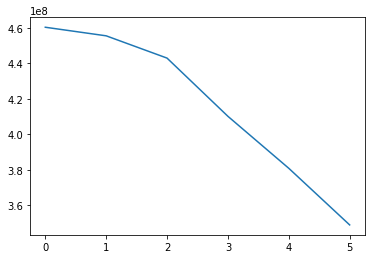

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-10)

losses = []
testlosses = []


for t in range(100):
    model.train() #学習モードに切り替え
    for x_train, today_price_train in train_loader:
      y_pred = model(x_train)
      loss = criterion(y_pred, today_price_train)
      losses.append(loss.data.item())
      # 勾配のリセットと勾配の計算
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    if t % 10 == 0:
        print(t, loss.data.item())
    
    model.eval()
    with torch.no_grad():
        y_test_pred = model(x_test)
        testloss = criterion(y_test_pred, today_price_test)
        testlosses.append(testloss)

plt.plot(losses)

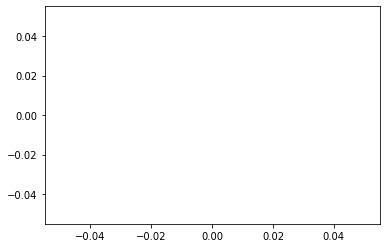

In [ ]:
plt.plot(testlosses)

In [ ]:
display(x_test.shape)
display(today_price_test.shape)

torch.Size([69, 404])

torch.Size([69, 1])

In [ ]:
# xxに対してsize個での移動平均を取る
def valid_convolve(xx, size):
    b = np.ones(size)/size
    xx_mean = np.convolve(xx, b, mode="same")

    n_conv = math.ceil(size/2)

    # 補正部分
    xx_mean[0] *= size/n_conv
    for i in range(1, n_conv):
        xx_mean[i] *= size/(i+n_conv)
        xx_mean[-i] *= size/(i + n_conv - (size % 2)) 
	# size%2は奇数偶数での違いに対応するため

    return xx_mean

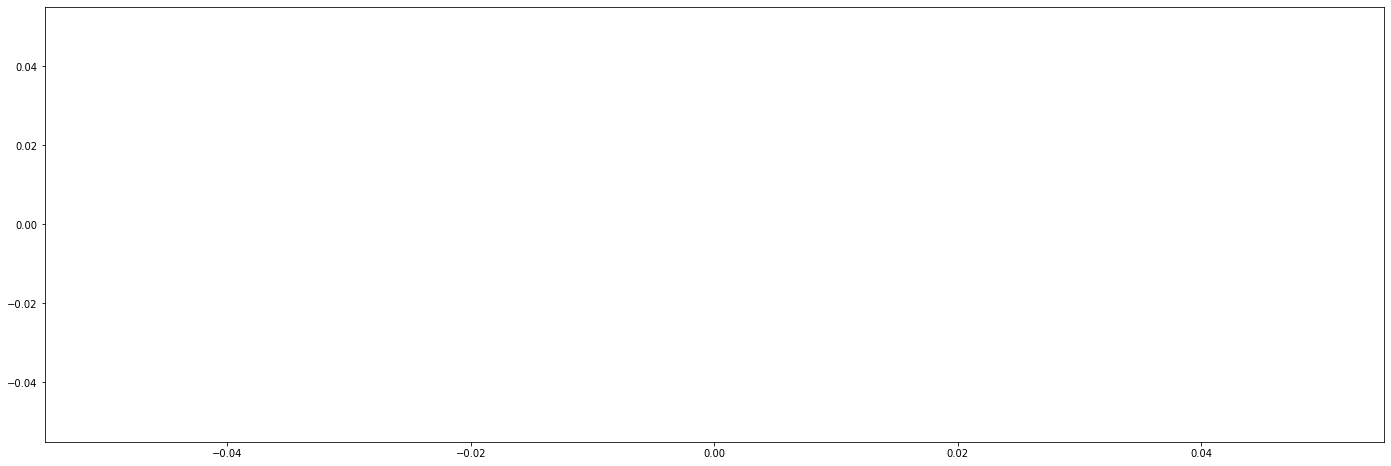

In [ ]:
train_ans = mlp_data_train["today_price"]
train_ans = torch.tensor(train_ans.values, dtype=torch.float32)

x_train = mlp_data_train.drop(["today_price","selling_money","number_of_sales"], axis=1)
x_train = torch.tensor(x_train.values.astype(np.float32))
today_price_train = mlp_data_train["today_price"]
model.eval()
with torch.no_grad():
    y_pred_tensor = model(x_train)

y_pred = y_pred_tensor.data.numpy()
train_ans = train_ans.data.numpy()
plt.figure(figsize=(24,8))
plt.plot(y_pred)
#plt.plot(train_ans)

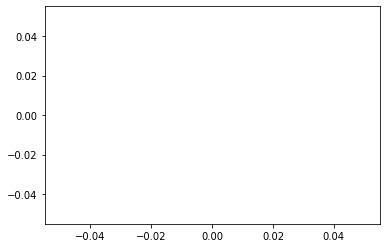

In [ ]:
plt.plot(y_pred)

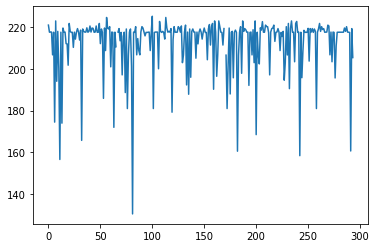

In [ ]:
plt.plot(today_price_train.tolist())

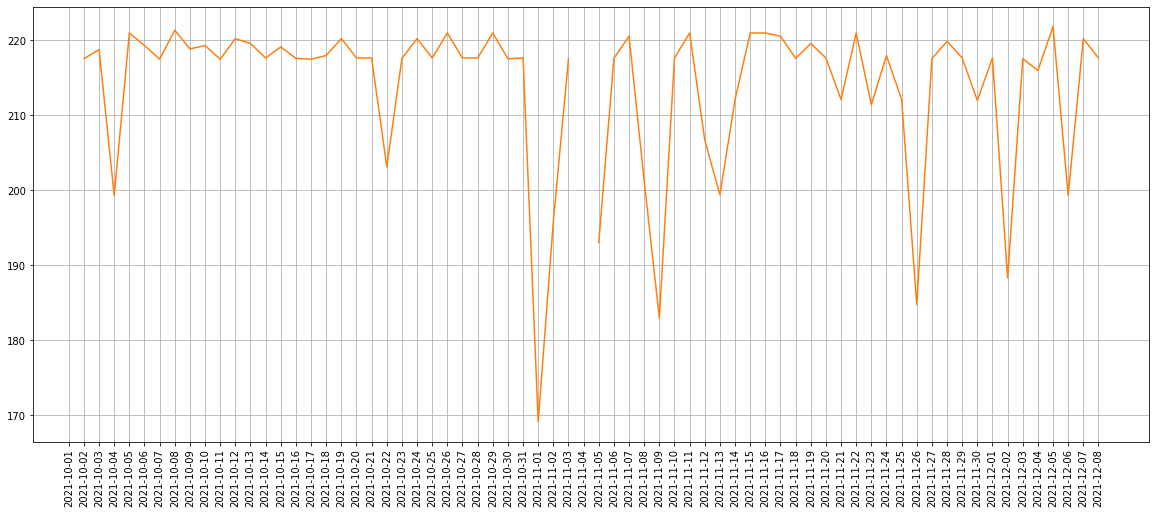

In [ ]:
# テストで比較
# 2021年10月1日を含め69日間のデータ
test_ans = mlp_data_test["today_price"]
test_ans = torch.tensor(test_ans.values, dtype=torch.float32)

x_test = mlp_data_test.drop(["today_price","selling_money","number_of_sales"], axis=1)
x_test = torch.tensor(x_test.values.astype(np.float32))
today_price_test = mlp_data_test["today_price"]
model.eval()
with torch.no_grad():
    y_pred_tensor = model(x_test)

y_pred = y_pred_tensor.data.numpy()
test_ans = test_ans.data.numpy()

# 横軸の設定
date_index = pd.date_range("2021-10-01", periods=69, freq="D")

plt.figure(figsize=(20,8))
plt.plot(date_index, y_pred)
plt.plot(date_index, test_ans)
plt.xticks(date_index, rotation=90)
plt.grid(True)

In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/dynamic_pricing/data/model2.pth'
torch.save(model.state_dict(), model_path)